In [1]:
!python3 -m pip install 'scipy<1.10.0,>=1.6.0' 'urllib3<2.0' matplotlib 'numpy<1.23' 'tensorflow<2.16' --user --force-reinstall

  Using cached scipy-1.9.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
  Using cached urllib3-1.26.20-py2.py3-none-any.whl.metadata (50 kB)
  Using cached matplotlib-3.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached numpy-1.22.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.0 kB)
  Using cached tensorflow-2.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached contourpy-1.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.55.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (164 kB)
  Using cached kiwisolver-1.4.7-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (6.3 kB)
INFO: pip is looking at multiple versions of matplotlib to determine which version is compatible with other require

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2024-11-21 10:44:01.546665: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 10:44:01.631764: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-21 10:44:01.970242: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-21 10:44:01.974243: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-21 10:44:04.267593: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

2.13.1


In [3]:
#a sinusoidal curve
def sinusoid(x,A,f,p):
    return A*np.sin(f*x+p)

In [4]:
#sinusoidal data with scatter
def generate_data(xmin=0.0, xmax=10.0, A=1.0, f=2.0, p=1.0, s=0.25, n=100):
    #xmin is the minimum range of the data
    #xmax is the maximum range of the data
    #A is the amplitude
    #f is the frequency
    #p is the phase
    #s is the gaussian std
    #n is the number of samples

    #pick a random location between xmin and xmax
    x = np.asarray(np.random.uniform(low=xmin,high=xmax,size=n),dtype=np.float32)

    #pick a random y location centered on the curve
    y = np.asarray(sinusoid(x,A,f,p) + s*np.random.randn(n),dtype=np.float32)

    #remember the y error
    y_err = np.full(n,s,dtype=np.float32)

    #return the x and y values
    return x,y,y_err

Go ahead and generate the data

In [5]:
x, y, y_err = generate_data()

Load the defaults for plotting

In [6]:
plt.style.use("./astr19_matplotlib_defaults.txt")

Plot the data

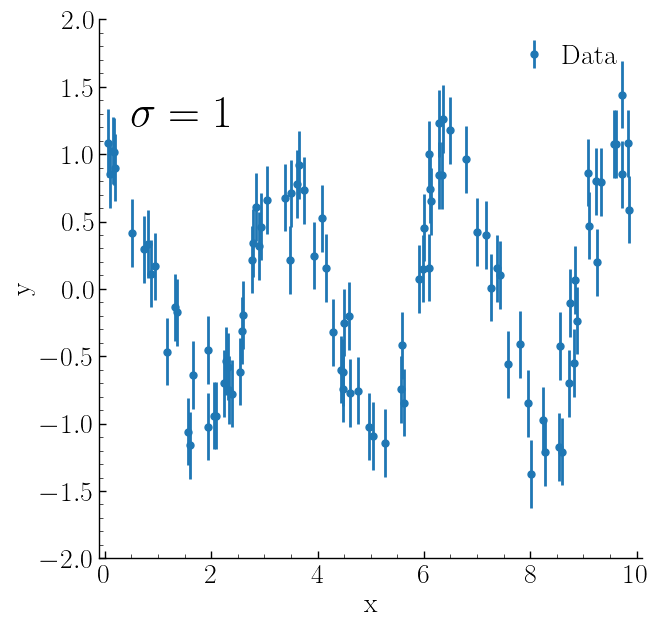

In [7]:
matplotlib.rcParams['font.family'] = ['Family1','serif','Family2']
matplotlib.rcParams['text.usetex'] = 'True'
f,ax = plt.subplots(1,1,figsize=(7,7))
for tick in ax.xaxis.get_ticklabels():
    tick.set_fontsize(20)
for tick in ax.yaxis.get_ticklabels():
    tick.set_fontsize(20)
ax.errorbar(x,y,y_err,fmt='o',label='Data')
ax.set_xlim([-0.1,10.1])
ax.set_ylim([-2.,2])
ax.text(0.5,1.2,r'$\sigma = 1$', color='0',fontsize=32)
ax.set_xlabel('x',fontsize=20)
ax.set_ylabel('y',fontsize=20)
plt.legend(frameon=False,fontsize=20,handletextpad=0)

Prepare our fitted model

In [8]:
#Amplitude
A_init = 2.0
A_fit = tf.Variable(A_init, name='amplitude')
#Frequency
f_init = 2.0
f_fit = tf.Variable(A_init, name='frequency')
#phase
p_init = 0.5
p_fit = tf.Variable(A_init, name='phase')

Define the function for tensorflow to fit

In [9]:
#define sinusoidal model
@tf.function
def sinusoidal_model(x):
    return A_fit*tf.math.sin(f_fit*x + p_fit)

Define the loss function using tensorflow

In [10]:
#define loss function
@tf.function
def mse(y_true, y_pred):
    #mse between true and predicted value
    return tf.losses.mean_squared_error(y_true,y_pred)

Define the optimizer that tells us how to do gradient descent

In [11]:
#Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

Train the model iteratively

In [12]:
#start training
epochs = 5000 #number of epochs to run
display_step = 1000 #number of epochs between printing info to screen

for epoch in range(epochs):
    #monitor training/display steps
    if((epoch%display_step)==0):
        pred = sinusoidal_model(x)
        loss = mse(pred, y)

        #To print this info, we need to convert to numpy arrays
        print(f"Epoch {epoch} | Loss {loss.numpy()}, A: {A_fit.numpy()} f: {f_fit.numpy()} p: {p_fit.numpy()}")

    #In TF2, gradients are handled using the GradientTape class. Begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = sinusoidal_model(x)
        loss = mse(y,pred)

    #Compute dm, db, the gradients with respect to m_fit and b_fit
    gradients = g.gradient(loss, [A_fit,f_fit,p_fit])

    #update m_fit and b_fit with the gradients x learning
    optimizer.apply_gradients(zip(gradients,[A_fit,f_fit,p_fit]))

#print the last answer!
print(f"Epoch {epoch} | Loss {loss.numpy()}, A: {A_fit.numpy()} f: {f_fit.numpy()} p: {p_fit.numpy()}")
print("Done!")

Epoch 0 | Loss 1.6082512140274048, A: 2.0 f: 2.0 p: 2.0
Epoch 1000 | Loss 0.15816034376621246, A: 1.305771827697754 f: 1.9000585079193115 p: 1.5767889022827148
Epoch 2000 | Loss 0.07760466635227203, A: 1.0239722728729248 f: 1.9487719535827637 p: 1.2886230945587158
Epoch 3000 | Loss 0.06965295225381851, A: 0.9925743937492371 f: 1.9779527187347412 p: 1.1011449098587036
Epoch 4000 | Loss 0.06883371621370316, A: 0.9934810400009155 f: 1.989542007446289 p: 1.025420904159546
Epoch 4999 | Loss 0.0688154399394989, A: 0.9935781359672546 f: 1.9914722442626953 p: 1.0128142833709717
Done!


Plot the data and best-fit model

In [13]:
x_model = np.sort(x)
y_model = sinusoid(x_model,A_fit,f_fit,p_fit)

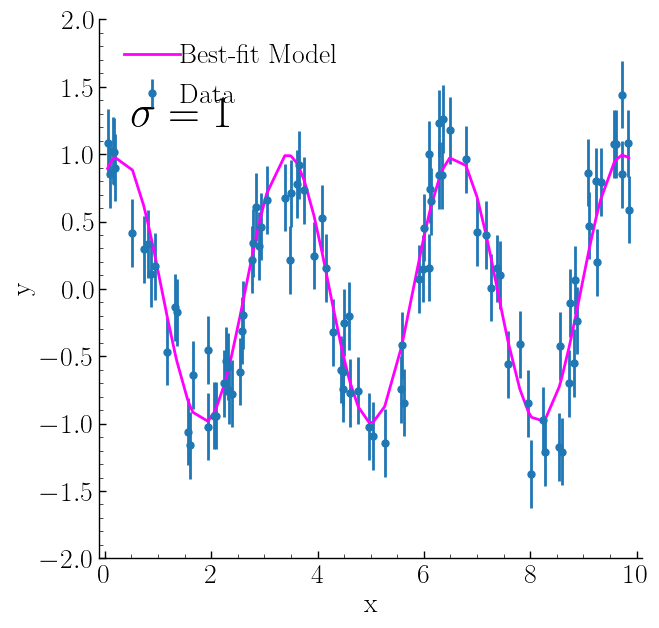

In [14]:
matplotlib.rcParams['font.family'] = ['Family1','serif','Family2']
matplotlib.rcParams['text.usetex'] = 'True'

f,ax = plt.subplots(1,1,figsize=(7,7))
for tick in ax.xaxis.get_ticklabels():
    tick.set_fontsize(20)
for tick in ax.yaxis.get_ticklabels():
    tick.set_fontsize(20)
ax.errorbar(x,y,y_err,fmt='o',label='Data')
ax.plot(x_model,y_model,color='magenta',label='Best-fit Model')
ax.set_xlim([-0.1,10.1])
ax.set_ylim([-2.,2])
ax.text(0.5,1.2,r'$\sigma = 1$',color='0',fontsize=32)
ax.set_xlabel('x',fontsize=20)
ax.set_ylabel('y',fontsize=20)
plt.legend(frameon=False,fontsize=20,handletextpad=0)

Now look at residuals between data and model

In [15]:
idx_model = np.argsort(x)
y_data = y[idx_model]
y_model = sinusoid(x[idx_model],A_fit,f_fit,p_fit)

residuals = y_data - y_model
residuals = residuals.numpy()

Plot the residuals

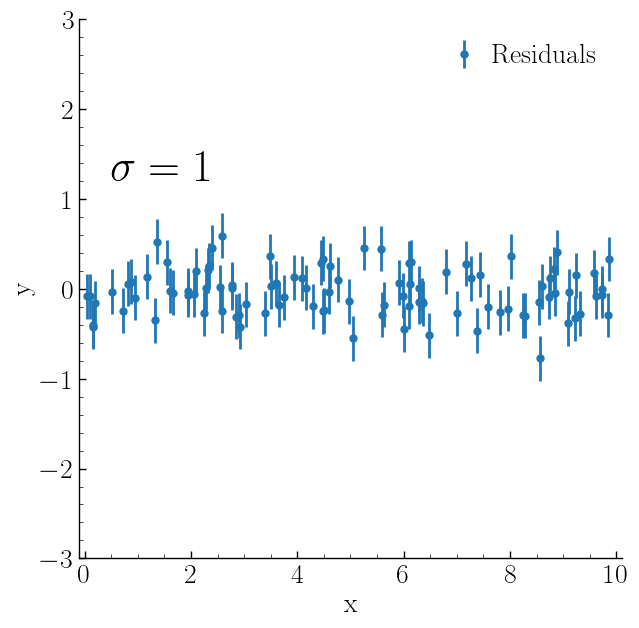

In [29]:
matplotlib.rcParams['font.family'] = ['Family1','serif','Family2']
matplotlib.rcParams['text.usetex'] = 'True'

f,ax = plt.subplots(1,1,figsize=(7,7))
for tick in ax.xaxis.get_ticklabels():
    tick.set_fontsize(20)
for tick in ax.yaxis.get_ticklabels():
    tick.set_fontsize(20)
ax.errorbar(x,residuals,y_err,fmt='o',label='Residuals')
ax.set_xlim([-0.1,10.1])
ax.set_ylim([-3.,3])
ax.text(0.5,1.2,r'$\sigma = 1$', color='0',fontsize=32)
ax.set_xlabel('x',fontsize=20)
ax.set_ylabel('y',fontsize=20)
plt.legend(frameon=False,fontsize=20,handletextpad=0)

Now look at the residuals between data and model

In [17]:
idx_model = np.argsort(x)
y_data = y[idx_model]
y_model = sinusoid(x[idx_model],A_fit,f_fit,p_fit)

residuals = y_data - y_model
residuals = residuals.numpy()

What are the statistical properties of the residuals?

In [18]:
residual_mean = np.mean(residuals)
residual_std = np.std(residuals)
print(f"Mean residual is {residual_mean}.")
print(f"RMS residual is {residual_std}.")

Mean residual is -0.03626338392496109.
RMS residual is 0.25980842113494873.


Define a gaussian function

In [19]:
def gaussian(x,mu,s):
    return 1./(2.*np.pi*s**2)**0.5 * np.exp(-0.5*((x-mu)/s)**2)

Histogram the residuals

100


Text(0, 0.5, 'N(x)')

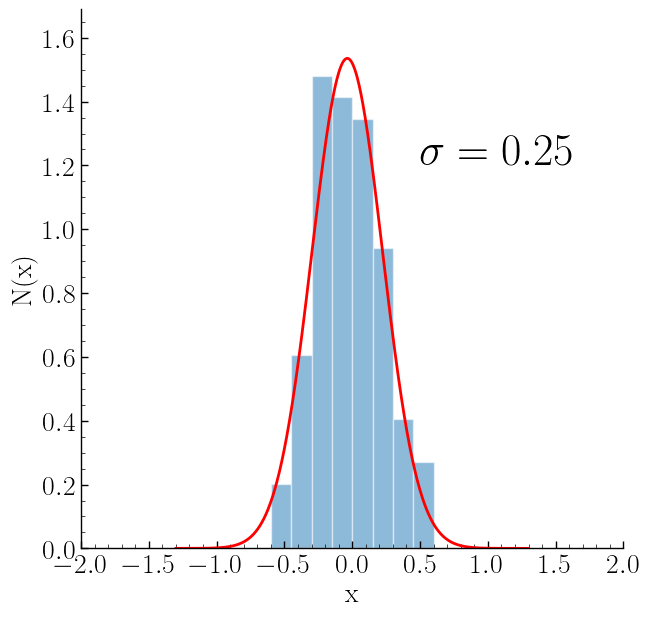

In [20]:
matplotlib.rcParams['font.family'] = ['Family1','serif','Family2']
matplotlib.rcParams['text.usetex'] = 'True'

f,ax = plt.subplots(1,1,figsize=(7,7))
for tick in ax.xaxis.get_ticklabels():
    tick.set_fontsize(20)
for tick in ax.yaxis.get_ticklabels():
    tick.set_fontsize(20)
    
print(len(residuals))
ax.hist(residuals,bins=10,range=(-0.75,0.75),alpha=0.5,edgecolor="white",density=True)

x_g = np.linspace(-5*residual_std,5*residual_std,1000)
ax.plot(x_g,gaussian(x_g,residual_mean,residual_std),color="red")
ax.set_xlim([-2,2])
ax.text(0.5,1.2,r'$\sigma = 0.25$', color='0',fontsize=32)
ax.set_xlabel('x',fontsize=20)
ax.set_ylabel('N(x)',fontsize=20)

Add an outlier to the data

In [21]:
xmin=0.0
xmax=10.0
A=1.0
f=2.0
p=1.0
s=0.25
x_out = np.random.uniform(low=xmin,high=xmax)
y_out = sinusoid(x_out,A,f,p) + 7*s
x_new = np.append(x,x_out)
y_new = np.append(y,y_out)
y_err_new = np.append(y_err,s)

Recompute the model including the new data location

In [22]:
idx_model = np.argsort(x_new)
y_data_new = y_new[idx_model]
y_model_new = sinusoid(x_new[idx_model],A_fit,f_fit,p_fit)

residuals_new = y_data_new - y_model_new
residuals_new = residuals_new.numpy()

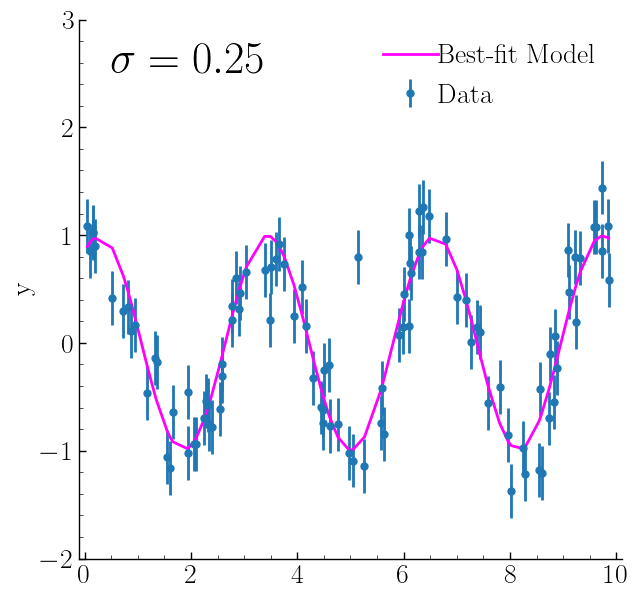

In [23]:
matplotlib.rcParams['font.family'] = ['Family1','serif','Family2']
matplotlib.rcParams['text.usetex'] = 'True'

f,ax = plt.subplots(1,1,figsize=(7,7))
for tick in ax.xaxis.get_ticklabels():
    tick.set_fontsize(20)
for tick in ax.yaxis.get_ticklabels():
    tick.set_fontsize(20)
ax.errorbar(x_new,y_new,y_err_new,fmt='o',label='Data')
ax.plot(x_model,y_model,color='magenta',label='Best-fit Model')
ax.set_xlim([-0.1,10.1])
ax.set_ylim([-2.,3])
ax.text(0.5,2.5,r'$\sigma = 0.25$',color='0',fontsize=32)
ax.set_ylabel('y',fontsize=20)
plt.legend(frameon=False,loc='upper right',fontsize=20,handletextpad=0)

Plot the residuals including the outlier

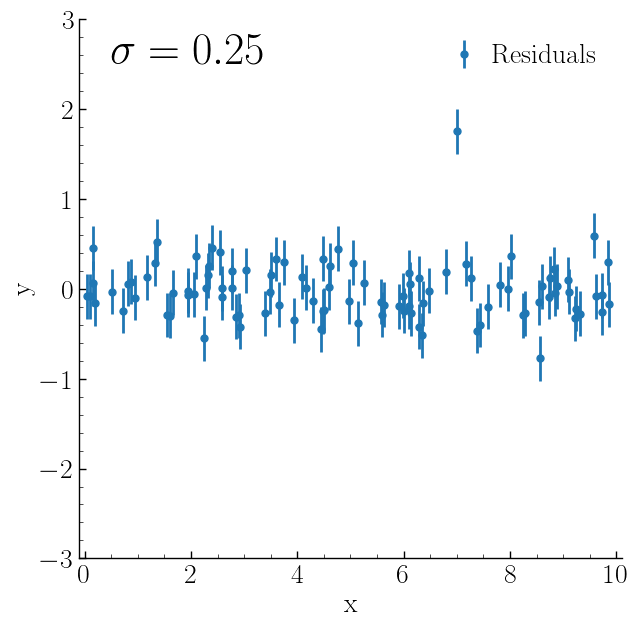

In [24]:
matplotlib.rcParams['font.family'] = ['Family1','serif','Family2']
matplotlib.rcParams['text.usetex'] = 'True'

f,ax = plt.subplots(1,1,figsize=(7,7))
for tick in ax.xaxis.get_ticklabels():
    tick.set_fontsize(20)
for tick in ax.yaxis.get_ticklabels():
    tick.set_fontsize(20)
ax.errorbar(x_new,residuals_new,y_err_new,fmt='o',label='Residuals')
ax.set_xlim([-0.1,10.1])
ax.set_ylim([-3.,3])
ax.text(0.5,2.5,r'$\sigma = 0.25$', color='0',fontsize=32)
ax.set_xlabel('x',fontsize=20)
ax.set_ylabel('y',fontsize=20)
plt.legend(frameon=False,fontsize=20,handletextpad=0)

Histogram the data with the outlier

Text(0, 0.5, 'N(x)')

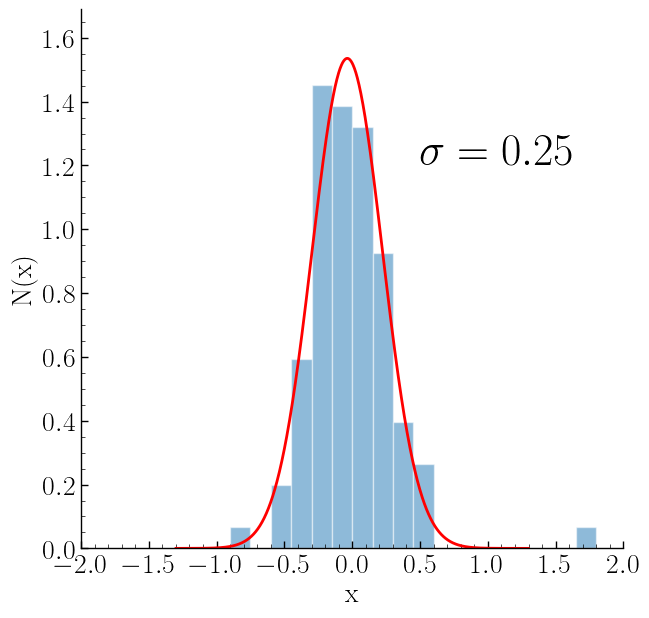

In [25]:
matplotlib.rcParams['font.family'] = ['Family1','serif','Family2']
matplotlib.rcParams['text.usetex'] = 'True'

f,ax = plt.subplots(1,1,figsize=(7,7))
for tick in ax.xaxis.get_ticklabels():
    tick.set_fontsize(20)
for tick in ax.yaxis.get_ticklabels():
    tick.set_fontsize(20)

ax.hist(residuals_new,bins=30,range=(-2.25,2.25),alpha=0.5,edgecolor="white",density=True)

x_g = np.linspace(-5*residual_std,5*residual_std,1000)
ax.plot(x_g,gaussian(x_g,residual_mean,residual_std),color="red")
ax.set_xlim([-2,2])
ax.text(0.5,1.2,r'$\sigma = 0.25$', color='0',fontsize=32)
ax.set_xlabel('x',fontsize=20)
ax.set_ylabel('N(x)',fontsize=20)

Histogram the data, normalized by the RMS

Text(0, 0.5, 'N(x)')

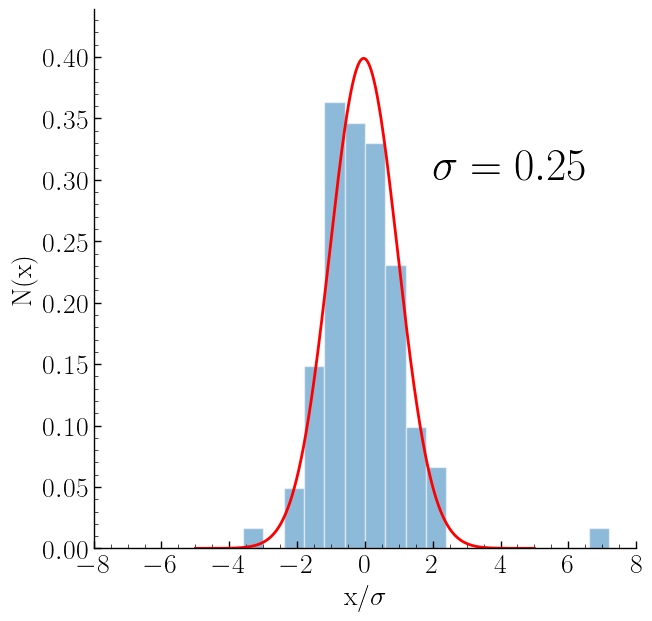

In [26]:
matplotlib.rcParams['font.family'] = ['Family1','serif','Family2']
matplotlib.rcParams['text.usetex'] = 'True'

f,ax = plt.subplots(1,1,figsize=(7,7))
for tick in ax.xaxis.get_ticklabels():
    tick.set_fontsize(20)
for tick in ax.yaxis.get_ticklabels():
    tick.set_fontsize(20)

ax.hist(residuals_new/0.25,bins=30,range=(-2.25/0.25,2.25/0.25),alpha=0.5,edgecolor="white",density=True)

x_g = np.linspace(-5*residual_std,5*residual_std,1000)
ax.plot(x_g/residual_std,gaussian(x_g/residual_std,residual_mean,1),color="red")
ax.set_xlim([-2/0.25,2/0.25])
ax.text(2,0.3,r'$\sigma = 0.25$', color='0',fontsize=32)
ax.set_xlabel(r'x/$\sigma$',fontsize=20)
ax.set_ylabel('N(x)',fontsize=20)